# 线性回归

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

pd.set_option('display.max_columns', None)

### 数据准备

In [2]:
tele = pd.read_csv('tele_camp_ok.csv')
tele.describe(include='all')

,Unnamed: 0,ID,Suc_flag,ARPU,PromCnt12,PromCnt36,PromCntMsg12,PromCntMsg36,Class,Age,Gender,HomeOwner,AvgARPU,AvgHomeValue,AvgIncome,Age_empflag,AvgHomeValue_empflag,AvgIncome_empflag,Age_group1,Age_group2
count,9686.000000,9686.000000,9686.000000,4843.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686,9686,9686.000000,9686.000000,9686.000000,9686,9686,9686,9686,9686
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN,2,2,2,4,4
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,H,NaN,NaN,NaN,False,False,False,"(51, 59.159]","(53.5, 69.75]"
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5223,5377,NaN,NaN,NaN,7278,9583,7329,3463,4549
mean,4842.500000,97975.474086,0.500000,78.121722,3.447212,7.337059,1.178402,2.390935,2.424530,59.230106,NaN,NaN,52.905156,112179.202755,53513.457361,NaN,NaN,NaN,NaN,NaN
std,2796.251688,56550.171120,0.500026,62.225686,1.231890,1.952436,0.287226,0.914314,1.049047,14.046835,NaN,NaN,4.993775,97997.592632,17227.468161,NaN,NaN,NaN,NaN,NaN
min,0.000000,12.000000,0.000000,5.000000,0.750000,1.000000,0.200000,0.400000,1.000000,21.000000,NaN,NaN,46.138968,7500.000000,2499.000000,NaN,NaN,NaN,NaN,NaN
25%,2421.250000,48835.500000,0.000000,50.000000,2.900000,6.250000,1.000000,1.400000,2.000000,51.000000,NaN,NaN,49.760116,53500.000000,42775.000000,NaN,NaN,NaN,NaN,NaN
50%,4842.500000,99106.000000,0.500000,65.000000,3.250000,7.750000,1.200000,2.600000,2.000000,59.158972,NaN,NaN,50.876672,78450.000000,53513.457361,NaN,NaN,NaN,NaN,NaN
75%,7263.750000,148538.750000,1.000000,100.000000,3.650000,8.250000,1.400000,3.200000,3.000000,69.000000,NaN,NaN,54.452822,128175.000000,56876.000000,NaN,NaN,NaN,NaN,NaN


In [3]:
#  抽取连续变量及分类变量以便后续使用
all_X = tele.columns[4:]
continuous_X = ['PromCnt12', 'PromCnt36', 'PromCntMsg12', 
                'PromCntMsg36', 'Age', 'AvgARPU', 'AvgHomeValue', 'AvgIncome']
categorical_X = list(set(all_X) - set(continuous_X))

- 对字符串变量进行编码

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
tele['Gender'] = le.fit_transform(tele['Gender'])    # 对Gender进行自动编码

tele['HomeOwner'].replace({'H': 0, 'U': 1}, inplace=True)

- 按ARPU是否为缺失值将数据分为两部分

In [5]:
arpu_known = tele[tele['ARPU'].notnull()].iloc[:, 3:].copy()
arpu_unknown = tele[tele['ARPU'].isnull()].iloc[:, 3:].copy()

相关性分析

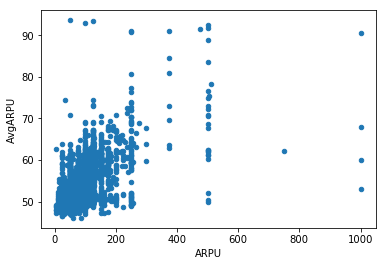

In [6]:
arpu_known.plot('ARPU', 'AvgARPU', kind='scatter')
plt.show()

In [7]:
arpu_known.corr(method='pearson')

,ARPU,PromCnt12,PromCnt36,PromCntMsg12,PromCntMsg36,Class,Age,Gender,HomeOwner,AvgARPU,AvgHomeValue,AvgIncome,Age_empflag,AvgHomeValue_empflag,AvgIncome_empflag
ARPU,1.000000,0.064494,0.007337,0.006996,-0.112374,0.317862,-0.047437,0.042839,0.007753,0.597952,0.127735,0.067225,-0.012554,0.008371,0.013994
PromCnt12,0.064494,1.000000,0.808929,0.694741,0.390750,0.017675,0.078353,0.003870,-0.001538,0.039907,0.034824,0.023357,-0.021731,-0.006053,-0.027813
PromCnt36,0.007337,0.808929,1.000000,0.740663,0.646368,-0.044956,0.079483,-0.006623,-0.025491,-0.031965,0.007877,0.005317,-0.092701,0.002205,-0.055108
PromCntMsg12,0.006996,0.694741,0.740663,1.000000,0.637776,-0.029329,0.036055,-0.009999,-0.035975,-0.040121,0.008232,0.012954,-0.048452,0.001553,-0.067848
PromCntMsg36,-0.112374,0.390750,0.646368,0.637776,1.000000,-0.158854,0.075378,-0.014626,-0.022885,-0.272162,-0.033199,-0.003391,-0.057321,0.024886,-0.045711
Class,0.317862,0.017675,-0.044956,-0.029329,-0.158854,1.000000,-0.076682,0.010066,-0.048225,0.139051,0.098393,0.074188,-0.034773,-0.017390,-0.001375
Age,-0.047437,0.078353,0.079483,0.036055,0.075378,-0.076682,1.000000,0.016881,0.006980,-0.060294,-0.001608,-0.046682,-0.027828,-0.023792,-0.020603
Gender,0.042839,0.003870,-0.006623,-0.009999,-0.014626,0.010066,0.016881,1.000000,0.047865,0.029681,0.005650,0.019644,0.062396,0.034300,0.078962
HomeOwner,0.007753,-0.001538,-0.025491,-0.035975,-0.022885,-0.048225,0.006980,0.047865,1.000000,-0.069979,-0.072810,-0.112049,0.401839,0.038057,0.587053
AvgARPU,0.597952,0.039907,-0.031965,-0.040121,-0.272162,0.139051,-0.060294,0.029681,-0.069979,1.000000,0.394561,0.252638,-0.042707,-0.034005,-0.050870


### 简单线性回归

In [9]:
lm_s = ols('ARPU ~ AvgARPU', data=arpu_known).fit()
lm_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ARPU   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     2694.
Date:                Tue, 25 Apr 2017   Prob (F-statistic):               0.00
Time:                        06:57:38   Log-Likelihood:                -25805.
No. Observations:                4843   AIC:                         5.161e+04
Df Residuals:                    4841   BIC:                         5.163e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   -327.8548      7.854    -41.742      0.000      -343.253  -312.457
AvgARPU        7.7267      0.149     51.905      0.000         7.435     8.019
==============================================================================
Omnibus:                     5446.316   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1148494.740
Skew:                           5.447   Prob(JB):                         0.00
Kurtosis:                      77.651   Cond. No.                         578.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 多元线性回归

In [10]:
formula = 'ARPU ~' + '+'.join(continuous_X)
lm = ols(formula, data=arpu_known).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ARPU   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     370.2
Date:                Tue, 25 Apr 2017   Prob (F-statistic):               0.00
Time:                        06:58:10   Log-Likelihood:                -25720.
No. Observations:                4843   AIC:                         5.146e+04
Df Residuals:                    4834   BIC:                         5.152e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept     -364.4043     10.096    -36.092      0.000      -384.198  -344.611
PromCnt12        5.0822      1.022      4.970      0.000         3.078     7.087
PromCnt36       -3.2888      0.769     -4.277      0.000        -4.796    -1.781
PromCntMsg12    -7.7304      4.165     -1.856      0.064       -15.896     0.435
PromCntMsg36     8.1472      1.257      6.483      0.000         5.683    10.611
Age             -0.0746      0.052     -1.437      0.151        -0.176     0.027
AvgARPU          8.7243      0.170     51.185      0.000         8.390     9.058
AvgHomeValue -6.952e-05   8.83e-06     -7.877      0.000     -8.68e-05 -5.22e-05
AvgIncome       -0.0001   4.95e-05     -2.897      0.004        -0.000 -4.63e-05
==============================================================================
Omnibus:                     5440.759   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1215928.238
Skew:                           5.412   Prob(JB):                         0.00
Kurtosis:                      79.867   Cond. No.                     2.34e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 线性回归的诊断

- 残差图

In [11]:
ana1 = lm_s

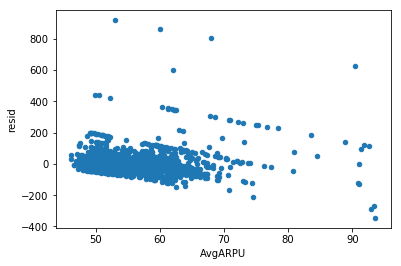

In [12]:
arpu_known['Pred'] = ana1.predict(arpu_known)
arpu_known['resid'] = ana1.resid
arpu_known.plot('AvgARPU', 'resid',kind='scatter')
plt.show()

- Find outlier：

In [13]:
# standardize the resid
resid_mean = arpu_known['resid'].mean(); resid_std = arpu_known['resid'].std()

arpu_known['resid_t'] = (arpu_known['resid'] - resid_mean) / resid_std

In [14]:
arpu_known[abs(arpu_known['resid_t']) > 2].head()

,ARPU,PromCnt12,PromCnt36,PromCntMsg12,PromCntMsg36,Class,Age,Gender,HomeOwner,AvgARPU,AvgHomeValue,AvgIncome,Age_empflag,AvgHomeValue_empflag,AvgIncome_empflag,Age_group1,Age_group2,Pred,resid,resid_t
52,200.0,9.15,13.75,2.4,4.4,2,57.000000,1,0,55.395079,86000.0,48783.000000,False,False,False,"(51, 59.159]","(53.5, 69.75]",100.167488,99.832512,2.001620
73,160.0,6.15,11.00,2.4,4.2,2,59.158972,1,1,49.293103,143500.0,53513.457361,True,False,True,"(51, 59.159]","(53.5, 69.75]",53.019232,106.980768,2.144940
99,200.0,5.90,10.50,2.4,4.4,3,67.000000,0,0,49.304746,103300.0,44032.000000,False,False,False,"(59.159, 69]","(53.5, 69.75]",53.109193,146.890807,2.945128
326,240.0,7.65,12.75,1.2,3.2,2,59.158972,0,0,57.230858,100000.0,48639.000000,True,False,False,"(51, 59.159]","(53.5, 69.75]",114.352037,125.647963,2.519214
332,250.0,6.65,11.75,1.4,1.2,3,32.000000,2,1,90.872000,87200.0,67852.000000,False,False,False,"[21, 51]","(20.935, 37.25]",374.287727,-124.287727,-2.491941


- drop outlier

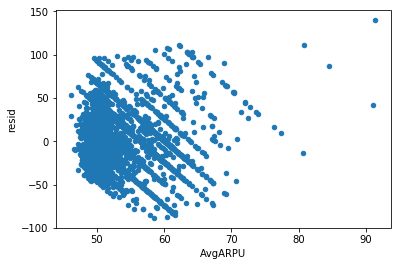

In [15]:
arpu_known2 = arpu_known[abs(arpu_known['resid_t']) <= 2].copy()
ana2 = ols('ARPU ~ AvgARPU', arpu_known2).fit()
arpu_known2['Pred'] = ana2.predict(arpu_known2)
arpu_known2['resid'] = ana2.resid
arpu_known2.plot('AvgARPU', 'resid', kind='scatter')
plt.show()

In [16]:
ana2.rsquared

0.46424165884664037

In [17]:
# statemodels包提供了更多强影响点判断指标
from statsmodels.stats.outliers_influence import OLSInfluence

OLSInfluence(ana1).summary_frame().head()

,dfb_Intercept,dfb_AvgARPU,cooks_d,dffits,dffits_internal,hat_diag,standard_resid,student_resid
0,-0.001411,0.001215,0.000003,-0.002522,-0.002522,0.000269,-0.153770,-0.153755
2,-0.006161,0.005451,0.000047,-0.009704,-0.009704,0.000302,-0.558637,-0.558597
3,0.014177,-0.013124,0.000160,0.017875,0.017876,0.000448,0.844415,0.844390
4,-0.008203,0.007532,0.000058,-0.010766,-0.010767,0.000404,-0.535265,-0.535226
5,0.003023,-0.002724,0.000009,0.004350,0.004350,0.000340,0.235975,0.235952


### 增加连续变量

- 多元线性回归的变量筛选

In [18]:
# 定义向前选择法变量筛选函数
def forward_select(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')
    while remaining:
        aic_with_candidates=[]
        for candidate in remaining:
            formula = "{} ~ {}".format(response,' + '.join(selected + [candidate]))
            aic = ols(formula=formula, data=data).fit().aic
            aic_with_candidates.append((aic, candidate))
        aic_with_candidates.sort(reverse=True)
        best_new_score, best_candidate=aic_with_candidates.pop()
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            print ('aic is {},continuing!'.format(current_score))
        else:        
            print ('forward selection over!')
            break
    formula = "{} ~ {} ".format(response,' + '.join(selected))
    print('final formula is {}'.format(formula))
    model = ols(formula=formula, data=data).fit()
    return(selected, model)

In [19]:
candidate_var = list(continuous_X)
candidate_var.append('ARPU')
data_for_select = arpu_known2[candidate_var]

selected_var, lm_m = forward_select(data=data_for_select, response='ARPU')  #  前向法选择变量
print(lm_m.rsquared)

aic is 45665.7338344,continuing!
aic is 45517.4565609,continuing!
aic is 45502.1622329,continuing!
aic is 45492.7721045,continuing!
aic is 45470.7719992,continuing!
aic is 45465.9903536,continuing!
aic is 45461.7353745,continuing!
forward selection over!
final formula is ARPU ~ AvgARPU + AvgHomeValue + PromCnt12 + PromCnt36 + PromCntMsg36 + AvgIncome + Age 
0.488241492349


### 多重共线性分析

Step regression is not always work.
The function "statsmodels.stats.outliers_influence.variance_inflation_factor" uses "OLS" to fit data, and it will generates a wrong rsquared. So define it ourselves!

In [20]:
def vif(df, col_i):
    cols = list(df.columns)
    cols.remove(col_i)
    cols_noti = cols
    formula = col_i + '~' + '+'.join(cols_noti)
    r2 = ols(formula, df).fit().rsquared
    return 1. / (1. - r2)

In [21]:
exog = arpu_known2[selected_var]

for i in exog.columns:
    print(i, '\t', vif(df=exog, col_i=i))

('AvgARPU', '\t', 1.3838275108868274)
('AvgHomeValue', '\t', 1.6664310643522966)
('PromCnt12', '\t', 3.1069634574720464)
('PromCnt36', '\t', 4.6240857908535871)
('PromCntMsg36', '\t', 2.1548580769562911)
('AvgIncome', '\t', 1.4967467141276576)
('Age', '\t', 1.0157723823596556)


### 增加分类变量

In [22]:
selected_var.extend(['C(Class)', 'C(Gender)'])
formula2 = 'ARPU ~' + '+'.join(selected_var)
ana3 = ols(formula2, arpu_known2).fit()
ana3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ARPU   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     585.9
Date:                Tue, 25 Apr 2017   Prob (F-statistic):               0.00
Time:                        07:00:31   Log-Likelihood:                -22146.
No. Observations:                4713   AIC:                         4.432e+04
Df Residuals:                    4700   BIC:                         4.440e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept       -321.1980      6.352    -50.569      0.000      -333.650  -308.746
C(Class)[T.2]     13.5930      1.075     12.640      0.000        11.485    15.701
C(Class)[T.3]     28.4215      1.157     24.566      0.000        26.153    30.690
C(Class)[T.4]     39.6483      1.197     33.118      0.000        37.301    41.995
C(Gender)[T.1]     0.5097      0.808      0.631      0.528        -1.074     2.094
C(Gender)[T.2]     1.7227      1.734      0.994      0.320        -1.676     5.122
AvgARPU            7.3175      0.113     64.666      0.000         7.096     7.539
AvgHomeValue   -6.181e-05   4.95e-06    -12.490      0.000     -7.15e-05 -5.21e-05
PromCnt12          3.1002      0.532      5.829      0.000         2.057     4.143
PromCnt36         -2.9244      0.426     -6.870      0.000        -3.759    -2.090
PromCntMsg36       6.6258      0.644     10.295      0.000         5.364     7.888
AvgIncome         -0.0001   2.73e-05     -3.799      0.000        -0.000 -5.02e-05
Age               -0.0114      0.029     -0.398      0.691        -0.068     0.045
==============================================================================
Omnibus:                      284.014   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              600.488
Skew:                           0.405   Prob(JB):                    4.03e-131
Kurtosis:                       4.550   Cond. No.                     2.66e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.66e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 增加交互效应

In [23]:
selected_var.append('C(Class):C(Gender)')
formula3 = 'ARPU ~' + '+'.join(selected_var)
ana4 = ols(formula3, arpu_known2).fit()
ana4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ARPU   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     391.0
Date:                Tue, 25 Apr 2017   Prob (F-statistic):               0.00
Time:                        07:00:47   Log-Likelihood:                -22143.
No. Observations:                4713   AIC:                         4.432e+04
Df Residuals:                    4694   BIC:                         4.445e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Intercept                     -320.6153      6.388    -50.193      0.000      -333.138  -308.093
C(Class)[T.2]                   12.8145      1.410      9.089      0.000        10.050    15.579
C(Class)[T.3]                   28.0178      1.563     17.931      0.000        24.954    31.081
C(Class)[T.4]                   39.5056      1.587     24.900      0.000        36.395    42.616
C(Gender)[T.1]                  -0.0184      1.571     -0.012      0.991        -3.098     3.061
C(Gender)[T.2]                  -0.9947      3.254     -0.306      0.760        -7.373     5.384
C(Class)[T.2]:C(Gender)[T.1]     1.6274      2.108      0.772      0.440        -2.506     5.760
C(Class)[T.3]:C(Gender)[T.1]     0.8174      2.336      0.350      0.726        -3.762     5.397
C(Class)[T.4]:C(Gender)[T.1]    -1.0081      2.436     -0.414      0.679        -5.783     3.767
C(Class)[T.2]:C(Gender)[T.2]     2.0309      4.530      0.448      0.654        -6.850    10.912
C(Class)[T.3]:C(Gender)[T.2]     1.3235      4.879      0.271      0.786        -8.242    10.889
C(Class)[T.4]:C(Gender)[T.2]     9.7080      5.176      1.876      0.061        -0.439    19.855
AvgARPU                          7.3136      0.113     64.596      0.000         7.092     7.536
AvgHomeValue                 -6.165e-05   4.95e-06    -12.451      0.000     -7.14e-05 -5.19e-05
PromCnt12                        3.1149      0.533      5.849      0.000         2.071     4.159
PromCnt36                       -2.9326      0.426     -6.885      0.000        -3.768    -2.098
PromCntMsg36                     6.6165      0.644     10.275      0.000         5.354     7.879
AvgIncome                       -0.0001   2.73e-05     -3.773      0.000        -0.000 -4.95e-05
Age                             -0.0120      0.029     -0.419      0.675        -0.068     0.044
==============================================================================
Omnibus:                      283.872   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              600.651
Skew:                           0.404   Prob(JB):                    3.72e-131
Kurtosis:                       4.551   Cond. No.                     3.09e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.09e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
selected_var.remove('C(Gender)')
selected_var.remove('C(Class):C(Gender)')
selected_var.remove('Age')

formula4 = 'ARPU ~' + '+'.join(selected_var)
ana5 = ols(formula4, arpu_known2).fit()
ana5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ARPU   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     781.4
Date:                Tue, 25 Apr 2017   Prob (F-statistic):               0.00
Time:                        07:00:58   Log-Likelihood:                -22147.
No. Observations:                4713   AIC:                         4.431e+04
Df Residuals:                    4703   BIC:                         4.438e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      -321.6766      6.033    -53.322      0.000      -333.503  -309.850
C(Class)[T.2]    13.6093      1.074     12.667      0.000        11.503    15.716
C(Class)[T.3]    28.4644      1.156     24.633      0.000        26.199    30.730
C(Class)[T.4]    39.6754      1.194     33.234      0.000        37.335    42.016
AvgARPU           7.3196      0.113     64.829      0.000         7.098     7.541
AvgHomeValue  -6.191e-05   4.94e-06    -12.530      0.000     -7.16e-05 -5.22e-05
PromCnt12         3.0973      0.531      5.831      0.000         2.056     4.139
PromCnt36        -2.9307      0.426     -6.887      0.000        -3.765    -2.096
PromCntMsg36      6.6213      0.643     10.291      0.000         5.360     7.883
AvgIncome        -0.0001   2.72e-05     -3.771      0.000        -0.000 -4.93e-05
==============================================================================
Omnibus:                      283.763   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              600.031
Skew:                           0.404   Prob(JB):                    5.07e-131
Kurtosis:                       4.550   Cond. No.                     2.53e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 正则算法

- 岭回归

In [25]:
reg_var = list(continuous_X)
reg_var.extend(['C(Class)', 'C(Gender)', 'C(Class):C(Gender)', 'C(HomeOwner)'])
formula5 = 'ARPU ~' + '+'.join(reg_var)
lmr = ols(formula5, data=arpu_known2).fit_regularized(alpha=0.01, L1_wt=0)
lmr.summary()
# L1_wt参数为0则使用岭回归，为1使用lasso

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ARPU   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     220.1
Date:                Tue, 25 Apr 2017   Prob (F-statistic):               0.00
Time:                        07:01:10   Log-Likelihood:                -22742.
No. Observations:                4713   AIC:                         4.553e+04
Df Residuals:                    4692   BIC:                         4.566e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Intercept                      -85.8472      7.345    -11.688      0.000      -100.247   -71.448
C(Class)[T.2]                   13.8668      1.602      8.657      0.000        10.727    17.007
C(Class)[T.3]                   24.4902      1.776     13.790      0.000        21.008    27.972
C(Class)[T.4]                   30.3293      1.804     16.813      0.000        26.793    33.866
C(Gender)[T.1]                  -4.7519      1.786     -2.661      0.008        -8.253    -1.251
C(Gender)[T.2]                  -2.1436      3.702     -0.579      0.563        -9.401     5.114
C(HomeOwner)[T.1]               -2.1064      0.909     -2.318      0.021        -3.888    -0.325
C(Class)[T.2]:C(Gender)[T.1]     7.4689      2.396      3.117      0.002         2.772    12.166
C(Class)[T.3]:C(Gender)[T.1]     8.5992      2.654      3.240      0.001         3.397    13.802
C(Class)[T.4]:C(Gender)[T.1]     4.8149      2.767      1.740      0.082        -0.610    10.239
C(Class)[T.2]:C(Gender)[T.2]     1.4952      5.146      0.291      0.771        -8.593    11.583
C(Class)[T.3]:C(Gender)[T.2]     2.5484      5.542      0.460      0.646        -8.316    13.412
C(Class)[T.4]:C(Gender)[T.2]     6.1657      5.881      1.048      0.294        -5.363    17.694
PromCnt12                        3.2666      0.653      4.999      0.000         1.986     4.548
PromCnt36                       -2.4448      0.487     -5.018      0.000        -3.400    -1.490
PromCntMsg12                    -5.1895      2.675     -1.940      0.052       -10.434     0.055
PromCntMsg36                    -0.7893      0.810     -0.974      0.330        -2.378     0.799
Age                             -0.3469      0.033    -10.644      0.000        -0.411    -0.283
AvgARPU                          3.6919      0.130     28.404      0.000         3.437     3.947
AvgHomeValue                  2.608e-06   5.63e-06      0.464      0.643     -8.42e-06  1.36e-05
AvgIncome                       -0.0003   3.11e-05     -8.038      0.000        -0.000    -0.000
==============================================================================
Omnibus:                     1074.316   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3233.508
Skew:                           1.170   Prob(JB):                         0.00
Kurtosis:                       6.315   Cond. No.                     3.09e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.09e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- LASSO算法

In [25]:
lml = ols(formula5, data=arpu_known2).fit_regularized(alpha=0.01, L1_wt=0)
lml.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ARPU   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     220.1
Date:                Tue, 25 Apr 2017   Prob (F-statistic):               0.00
Time:                        03:32:48   Log-Likelihood:                -22742.
No. Observations:                4713   AIC:                         4.553e+04
Df Residuals:                    4692   BIC:                         4.566e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Intercept                      -85.8472      7.345    -11.688      0.000      -100.247   -71.448
C(Class)[T.2]                   13.8668      1.602      8.657      0.000        10.727    17.007
C(Class)[T.3]                   24.4902      1.776     13.790      0.000        21.008    27.972
C(Class)[T.4]                   30.3293      1.804     16.813      0.000        26.793    33.866
C(Gender)[T.1]                  -4.7519      1.786     -2.661      0.008        -8.253    -1.251
C(Gender)[T.2]                  -2.1436      3.702     -0.579      0.563        -9.401     5.114
C(HomeOwner)[T.1]               -2.1064      0.909     -2.318      0.021        -3.888    -0.325
C(Class)[T.2]:C(Gender)[T.1]     7.4689      2.396      3.117      0.002         2.772    12.166
C(Class)[T.3]:C(Gender)[T.1]     8.5992      2.654      3.240      0.001         3.397    13.802
C(Class)[T.4]:C(Gender)[T.1]     4.8149      2.767      1.740      0.082        -0.610    10.239
C(Class)[T.2]:C(Gender)[T.2]     1.4952      5.146      0.291      0.771        -8.593    11.583
C(Class)[T.3]:C(Gender)[T.2]     2.5484      5.542      0.460      0.646        -8.316    13.412
C(Class)[T.4]:C(Gender)[T.2]     6.1657      5.881      1.048      0.294        -5.363    17.694
PromCnt12                        3.2666      0.653      4.999      0.000         1.986     4.548
PromCnt36                       -2.4448      0.487     -5.018      0.000        -3.400    -1.490
PromCntMsg12                    -5.1895      2.675     -1.940      0.052       -10.434     0.055
PromCntMsg36                    -0.7893      0.810     -0.974      0.330        -2.378     0.799
Age                             -0.3469      0.033    -10.644      0.000        -0.411    -0.283
AvgARPU                          3.6919      0.130     28.404      0.000         3.437     3.947
AvgHomeValue                  2.608e-06   5.63e-06      0.464      0.643     -8.42e-06  1.36e-05
AvgIncome                       -0.0003   3.11e-05     -8.038      0.000        -0.000    -0.000
==============================================================================
Omnibus:                     1074.316   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3233.508
Skew:                           1.170   Prob(JB):                         0.00
Kurtosis:                       6.315   Cond. No.                     3.09e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.09e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### scikit-learn中正则化参数调优

哑变量变换

In [26]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
dummies = enc.fit_transform(arpu_known2[['Gender', 'HomeOwner', 'Class']]).toarray()

In [27]:
X = arpu_known2[continuous_X].join(pd.DataFrame(dummies, index=arpu_known2.index))
y = arpu_known2[['ARPU', ]]

搜索最优正则化系数

In [28]:
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-3, 2, 100, base=10)#linspace

rcv = RidgeCV(alphas=alphas, store_cv_values=True) # Search the min MSE by CV
rcv.fit(X, y)

RidgeCV(alphas=array([  1.00000e-03,   1.12332e-03, ...,   8.90215e+01,   1.00000e+02]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=True)

In [29]:
print('The best alpha is {}'.format(rcv.alpha_))
print('The r-square is {}'.format(rcv.score(X,y))) # Default score is rsquared

The best alpha is 10.9749876549
The r-square is 0.599959415549


预测

In [30]:
rcv.predict(X)[:5]

array([[ 85.40634577],
       [ 38.16065199],
       [ 32.16469149],
       [ 33.22970851],
       [ 55.99281135]])

In [31]:
dummies_new = enc.transform(arpu_unknown[['Gender', 'HomeOwner', 'Class']]).toarray()
X_new = arpu_unknown[continuous_X].join(pd.DataFrame(dummies_new, index=arpu_unknown.index))

rcv.predict(X_new)[:5]

array([[  67.14242781],
       [  49.88019764],
       [  69.76792445],
       [  79.99855878],
       [ 123.659827  ]])